<h1 style="color: rgb(0, 0, 119);font-size: 7rem;font-family: 'Trebuchet MS', 'Lucida Sans Unicode', 'Lucida Grande', 'Lucida Sans', Arial, sans-serif;font-weight: bolder;text-align: center;">Compression d’images Méthode 2</h1>
<br><br><br><br>

<h1 style="color: rgb(0, 172, 172);font-size: 3rem;font-family: 'Trebuchet MS', 'Lucida Sans Unicode', 'Lucida Grande', 'Lucida Sans', Arial, sans-serif;font-weight: bolder;">>>> bibliothèques :</h1>

In [1]:
from matplotlib.pylab import plt
import numpy as np
import pickle
from PIL import Image
from imshowpair import imshowpair
import cv2
import os

<h1 style="color: rgb(0, 172, 172);font-size: 3rem;font-family: 'Trebuchet MS', 'Lucida Sans Unicode', 'Lucida Grande', 'Lucida Sans', Arial, sans-serif;font-weight: bolder;">>>> Functions :</h1>

In [2]:
def ReadImage(path):
    img = Image.open(path)
    if img.mode == 'RGB':
        img = np.array(img)
        LC = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        mode = 2
        return LC,mode
    elif img.mode == 'L':
        a_img = np.array(img)
        mode = 0
        return a_img,mode
    elif img.mode == 'P':
        c_img = img.quantize(method=0,colors=256) 
        palette = c_img.getpalette()
        a_img = np.array(c_img)
        mode = 1
        return a_img,mode,palette
def img_to_txt(I):
    sh = I.shape
    im = np.ravel(I, order='F')
    T = ''
    for i in im:
        T += chr(int(i))
    return T,sh

def txt_to_img(T,sh):
    M = []
    for i in T:
        M.append(ord(i))
    return np.array(M).reshape(sh,order='F')
def codage_LZW(M):
    w = ""
    code = []
    dict_size = 256
    D = {chr(i): i for i in range(dict_size)}
    for c in M:
        wc = w + c
        if wc in D:
            w = wc
        else:
            code.append(D[w])
            D[wc] = dict_size
            dict_size += 1
            w = c
    if w:
        code.append(D[w])
    return code
def decodage_LZW(M):
    dict_size = 256
    D = {i: chr(i) for i in range(dict_size)}
    w = chr(M[0])
    M = M[1:]
    code = w
    e = w
    for i in M:
        if i in D.keys():
            e = D[i]
        elif i == dict_size:
            e = w + w[0]
        code += e
        D[dict_size] = w + e[0]
        dict_size += 1
        w = e
    return code

def LZW_img(I,op):
    if op == "decodage":
        if I[3] == 0:
            i_img = txt_to_img(decodage_LZW(I[6:]),I[4:6])
            c_img = Image.fromarray(i_img.astype(np.uint8),"L")
        elif I[3] == 1 :
            i_img = txt_to_img(decodage_LZW(I[774:]),I[4:6])
            c_img = Image.fromarray(i_img.astype(np.uint8),"P")
            c_img.putpalette(I[6:774].tolist())
        elif I[3] == 2 :
            i_img = txt_to_img(decodage_LZW(I[7:]),I[4:7])
            f_img = cv2.cvtColor(i_img.astype(np.uint8), cv2.COLOR_YCrCb2RGB)
            c_img = Image.fromarray(f_img,"RGB")
        return c_img
    elif op == "codage":
        C = img_to_txt(I[0])
        CC = [73,  82,  77]
        if I[1] == 0 :
            CC.append(I[1])
            CC.extend(C[1])
            CC.extend(codage_LZW(C[0]))
        elif I[1] == 1 :
            CC.append(I[1])
            CC.extend(C[1])
            CC.extend(I[2])
            CC.extend(codage_LZW(C[0]))
        elif I[1] == 2 :
            CC.append(I[1])
            CC.extend(C[1])
            CC.extend(codage_LZW(C[0]))
        return np.array(CC)
def Save(path,A):
    with open(path,'wb') as op:
        op.write(A.tobytes())
def Load(path):
    with open("hh2.irm",'rb') as op:
        res = np.frombuffer(op.read(),dtype=int)
    return res

<h1 style="color: rgb(0, 172, 172);font-size: 3rem;font-family: 'Trebuchet MS', 'Lucida Sans Unicode', 'Lucida Grande', 'Lucida Sans', Arial, sans-serif;font-weight: bolder;">>>> Test :</h1>

In [3]:
img = ReadImage("sample_1920×1280.bmp")
L = LZW_img(img,"codage")

In [4]:
L

array([    73,     82,     77, ..., 184844, 221422,     90])

In [5]:
Save("hh2.irm",L)

In [6]:
res = Load("hh2.irm")

In [7]:
res

array([    73,     82,     77, ..., 184844, 221422,     90])

In [8]:
f = np.array(LZW_img(L,"decodage"))

In [9]:
i = np.array(Image.open("sample_1920×1280.bmp"))

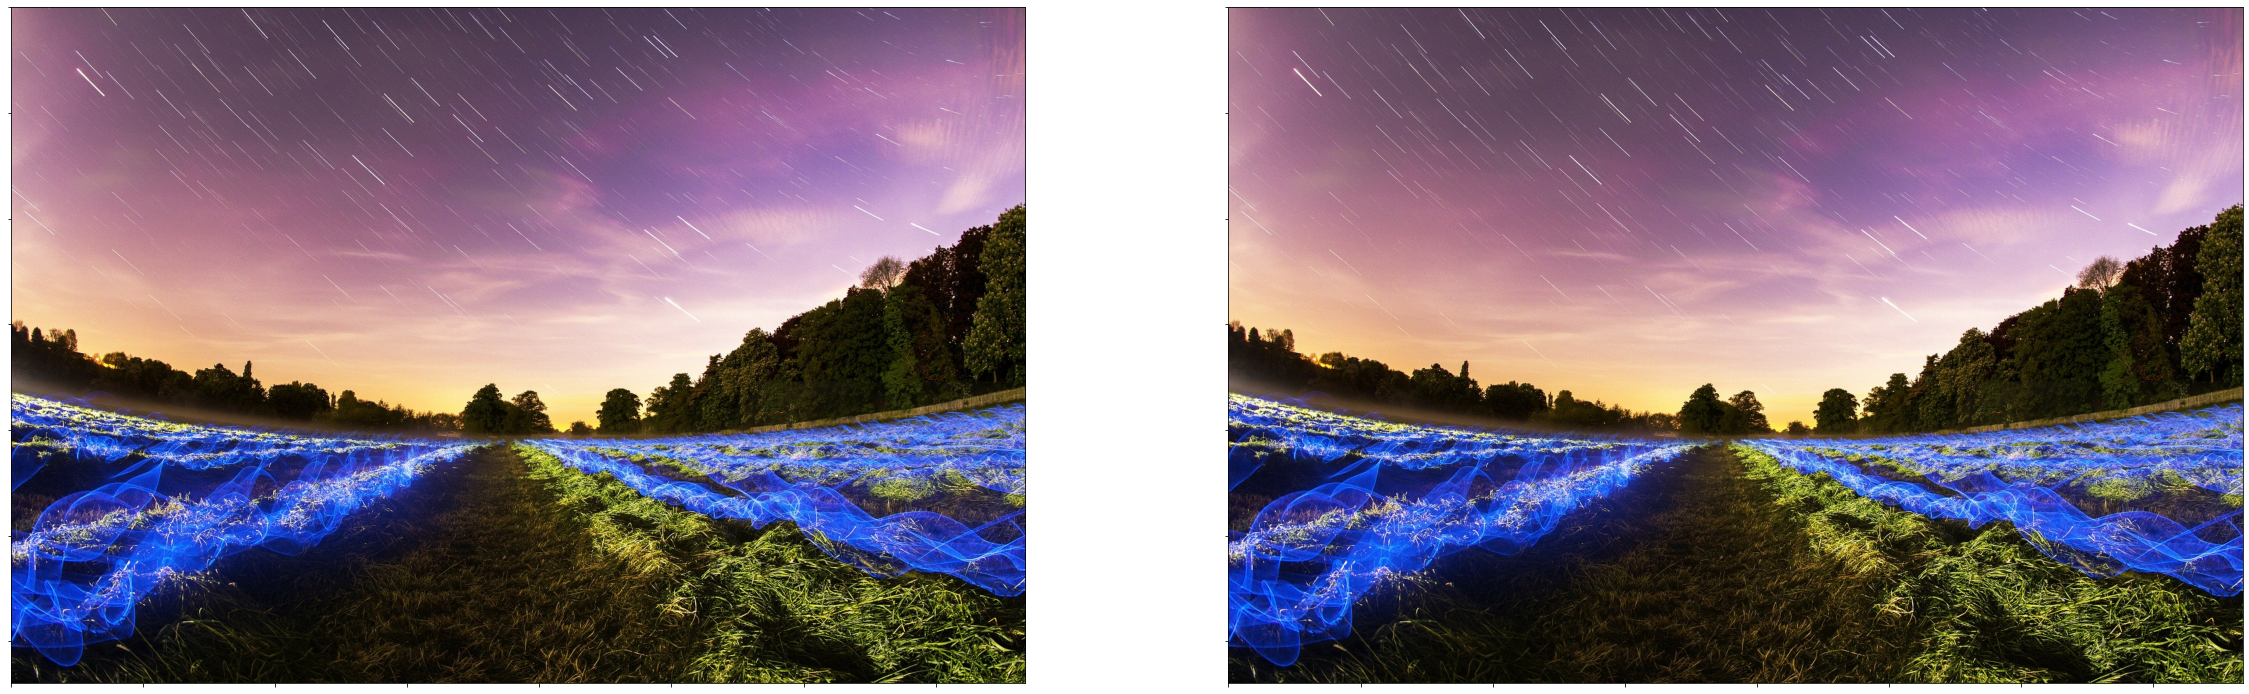

In [10]:
plt.figure(figsize=(40,50))
imshowpair(i,f)

<h1 style="color: rgb(0, 172, 172);font-size: 3rem;font-family: 'Trebuchet MS', 'Lucida Sans Unicode', 'Lucida Grande', 'Lucida Sans', Arial, sans-serif;font-weight: bolder;">>>> Mesure de distorsion :</h1>

In [11]:
def tauxCompression(pathOriginal,pathCompresse):
    i=os.path.getsize(pathOriginal)
    f=os.path.getsize(pathCompresse)
    taux=1-(f/i)
    return np.round(taux*100,2)

tauxCompression('sample_1920×1280.bmp','hh2.irm')

8.46

In [12]:
def errquadra(i,f):
    z=np.mean((i-f)**2)
    return z

errquadra(i,f)

0.04785685221354167

In [13]:
def SNR(i,f):
    v=np.mean(i**2)
    mse=errquadra(i,f)
    z=10*np.log(v/mse)
    return z
SNR(i,f)

76.70879855819025

In [14]:
def PSNR(i,f):
    m=np.max(i**2)
    mse=errquadra(i,f)
    z=10*np.log(m/mse)
    return z


PSNR(i,f)

85.56993865845408